The goal is to create a Pearson Correlation analysis on all crypto pairs OHLCV data to find which ones are strongly correlated or inversely correlated. 
The price data collected ranges from January 2020 to January 19 2023, since pre bull market 2021 through the 2022 bear market.

Correlation is a statistical measure that shows the linear relationship between two independant variables. When it comes to financial market analysis 
correlation is an important metric as it reveals how each asset behaves in parallel to others, how correlated are the price action of different financial
assets. 

We will use the Pearson correlation coefficient, here noted r, as a our measure for quantifying the linear relationship between two assets.
R measure how strongly two assets tend evolve in the same or the opposite directions

In order to generate meaningful r values our code has to meet the following requirements:

- the samples of each asset are independent of each other
- all variables are metrically scaled and continuous
- the relationship between any given 2 assets must be approximately linear.

A correlation measures how strong two variables are related.
Pearson Correlation by dividing the covariance of two assets prices BY their standard deviations.

The value r is between -1 and 1.
The closer r is to 1 => the stronger the direct relationship = strong direct correlation (i.e: two assets prices moving in same directions and similar momentum).
The closer r is to 0 => the weaker the correlation is.
The close r is to -1 => the stronger the inverse relationship = strong inverse correlation (i.e: two assets prices moving in opposite directions and similar momentum).

Despite the findings here, we must keep in mind that correlation is not explanatory, a strong r value simply shows that correlation exists and not why such 
a correlation exists. When it comes to crypto, many believe that the prices of these risk-on assets move in the same direction because the sell-offs and purchases 
follow the same trading motives: 
    1_ buying in a clear bullish trend or as a reaction to positive news, tech stocks showing great performance, optimistic economic news/data.
    2_ selling off risk assets to switch to safe hedges such as Corporate bonds, short-term CD, Treasury instruments... or simply Cash!

However, we find many inverse correlations between some cryptocurrencies which might be explained by complex dynamics related to staking, DeFi and tokenomics of 
some projects.

In [2]:
# Module & Libraries

import numpy as np
import pandas as pd

from datetime import datetime

from matplotlib import pyplot as plt 
import matplotlib.dates as mdates
import json 
import requests
import os
import glob

import seaborn as sns
from pandas.plotting import register_matplotlib_converters


ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# Storing all files in a variable
files = glob.glob('1h_data_Jan192023/*.csv')
# files = glob.glob(r'C:\Users\hp\Desktop\Projects Coding\Crypto_Analysis_Jan_19_2023\btc denominated_1h_Jan2020_Jan2023\*.csv')

# Opening each csv stored in files.
# Then, concatenating while adding filename as a prefix to each column.
df = pd.concat([pd.read_csv(fp).add_prefix(os.path.basename(fp).split('.')[0] + '_') for fp in files], axis = 1)

# Saving a date column for the correlation later
df['date'] = df["BTC-USDT_date"]

# Moving the df['date'] column to the first position/ index 0
first_position = df.pop('date')
# Moving to date to index 0 and renaming as Time
df.insert(0, 'Time', first_position)

# We are only interested in the price close values.
# Dropping all column containing the term '_date', '_open', '_high', '_low'
df = df.loc[:, ~df.columns.str.contains('_date', case = False)]
df = df.loc[:, ~df.columns.str.contains('_open', case = False)]
df = df.loc[:, ~df.columns.str.contains('_high', case = False)]
df = df.loc[:, ~df.columns.str.contains('_low', case = False)]

# # Converting timestamp to a readable date format
df['Time'] = pd.to_datetime(df['Time'], unit = 'ms')

# Final dataframe with Close values, Volume and Time as index
# Previewing 
df.head(3)

C:\Users\hp\AppData\Local\Temp\ipykernel_5728\3802892001.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['date'] = df["BTC-USDT_date"]
C:\Users\hp\AppData\Local\Temp\ipykernel_5728\3802892001.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(0, 'Time', first_position)


,Time,1INCH-USDT_close,1INCH-USDT_volume,ALGO-USDT_close,ALGO-USDT_volume,ALICE-USDT_close,ALICE-USDT_volume,ANT-USDT_close,ANT-USDT_volume,APE-USDT_close,...,THETA-USDT_close,THETA-USDT_volume,UNI-USDT_close,UNI-USDT_volume,WOO-USDT_close,WOO-USDT_volume,XLM-USDT_close,XLM-USDT_volume,XMR-USDT_close,XMR-USDT_volume
0,2020-01-01 00:00:00,2.5826,13125130.77,0.2167,37561.72,18.5925,13705897.48,8.4771,867891.60,8.9091,...,0.08683,15371.8,3.0072,5926008.35,0.7836,10457748.8,0.04488,210820.1,44.57,1017.44120
1,2020-01-01 01:00:00,2.5059,9270672.93,0.2175,22873.37,22.4282,10949342.22,7.9189,587705.54,7.3658,...,0.08802,62180.6,2.6383,3802775.00,0.8045,5369876.3,0.04517,824308.3,44.88,747.40031
2,2020-01-01 02:00:00,2.6237,7923760.56,0.2179,14671.09,38.5035,12221651.50,8.3465,359291.83,8.2527,...,0.08800,98193.8,2.5119,3180398.24,0.7736,2432862.4,0.04523,373344.2,45.02,350.18785


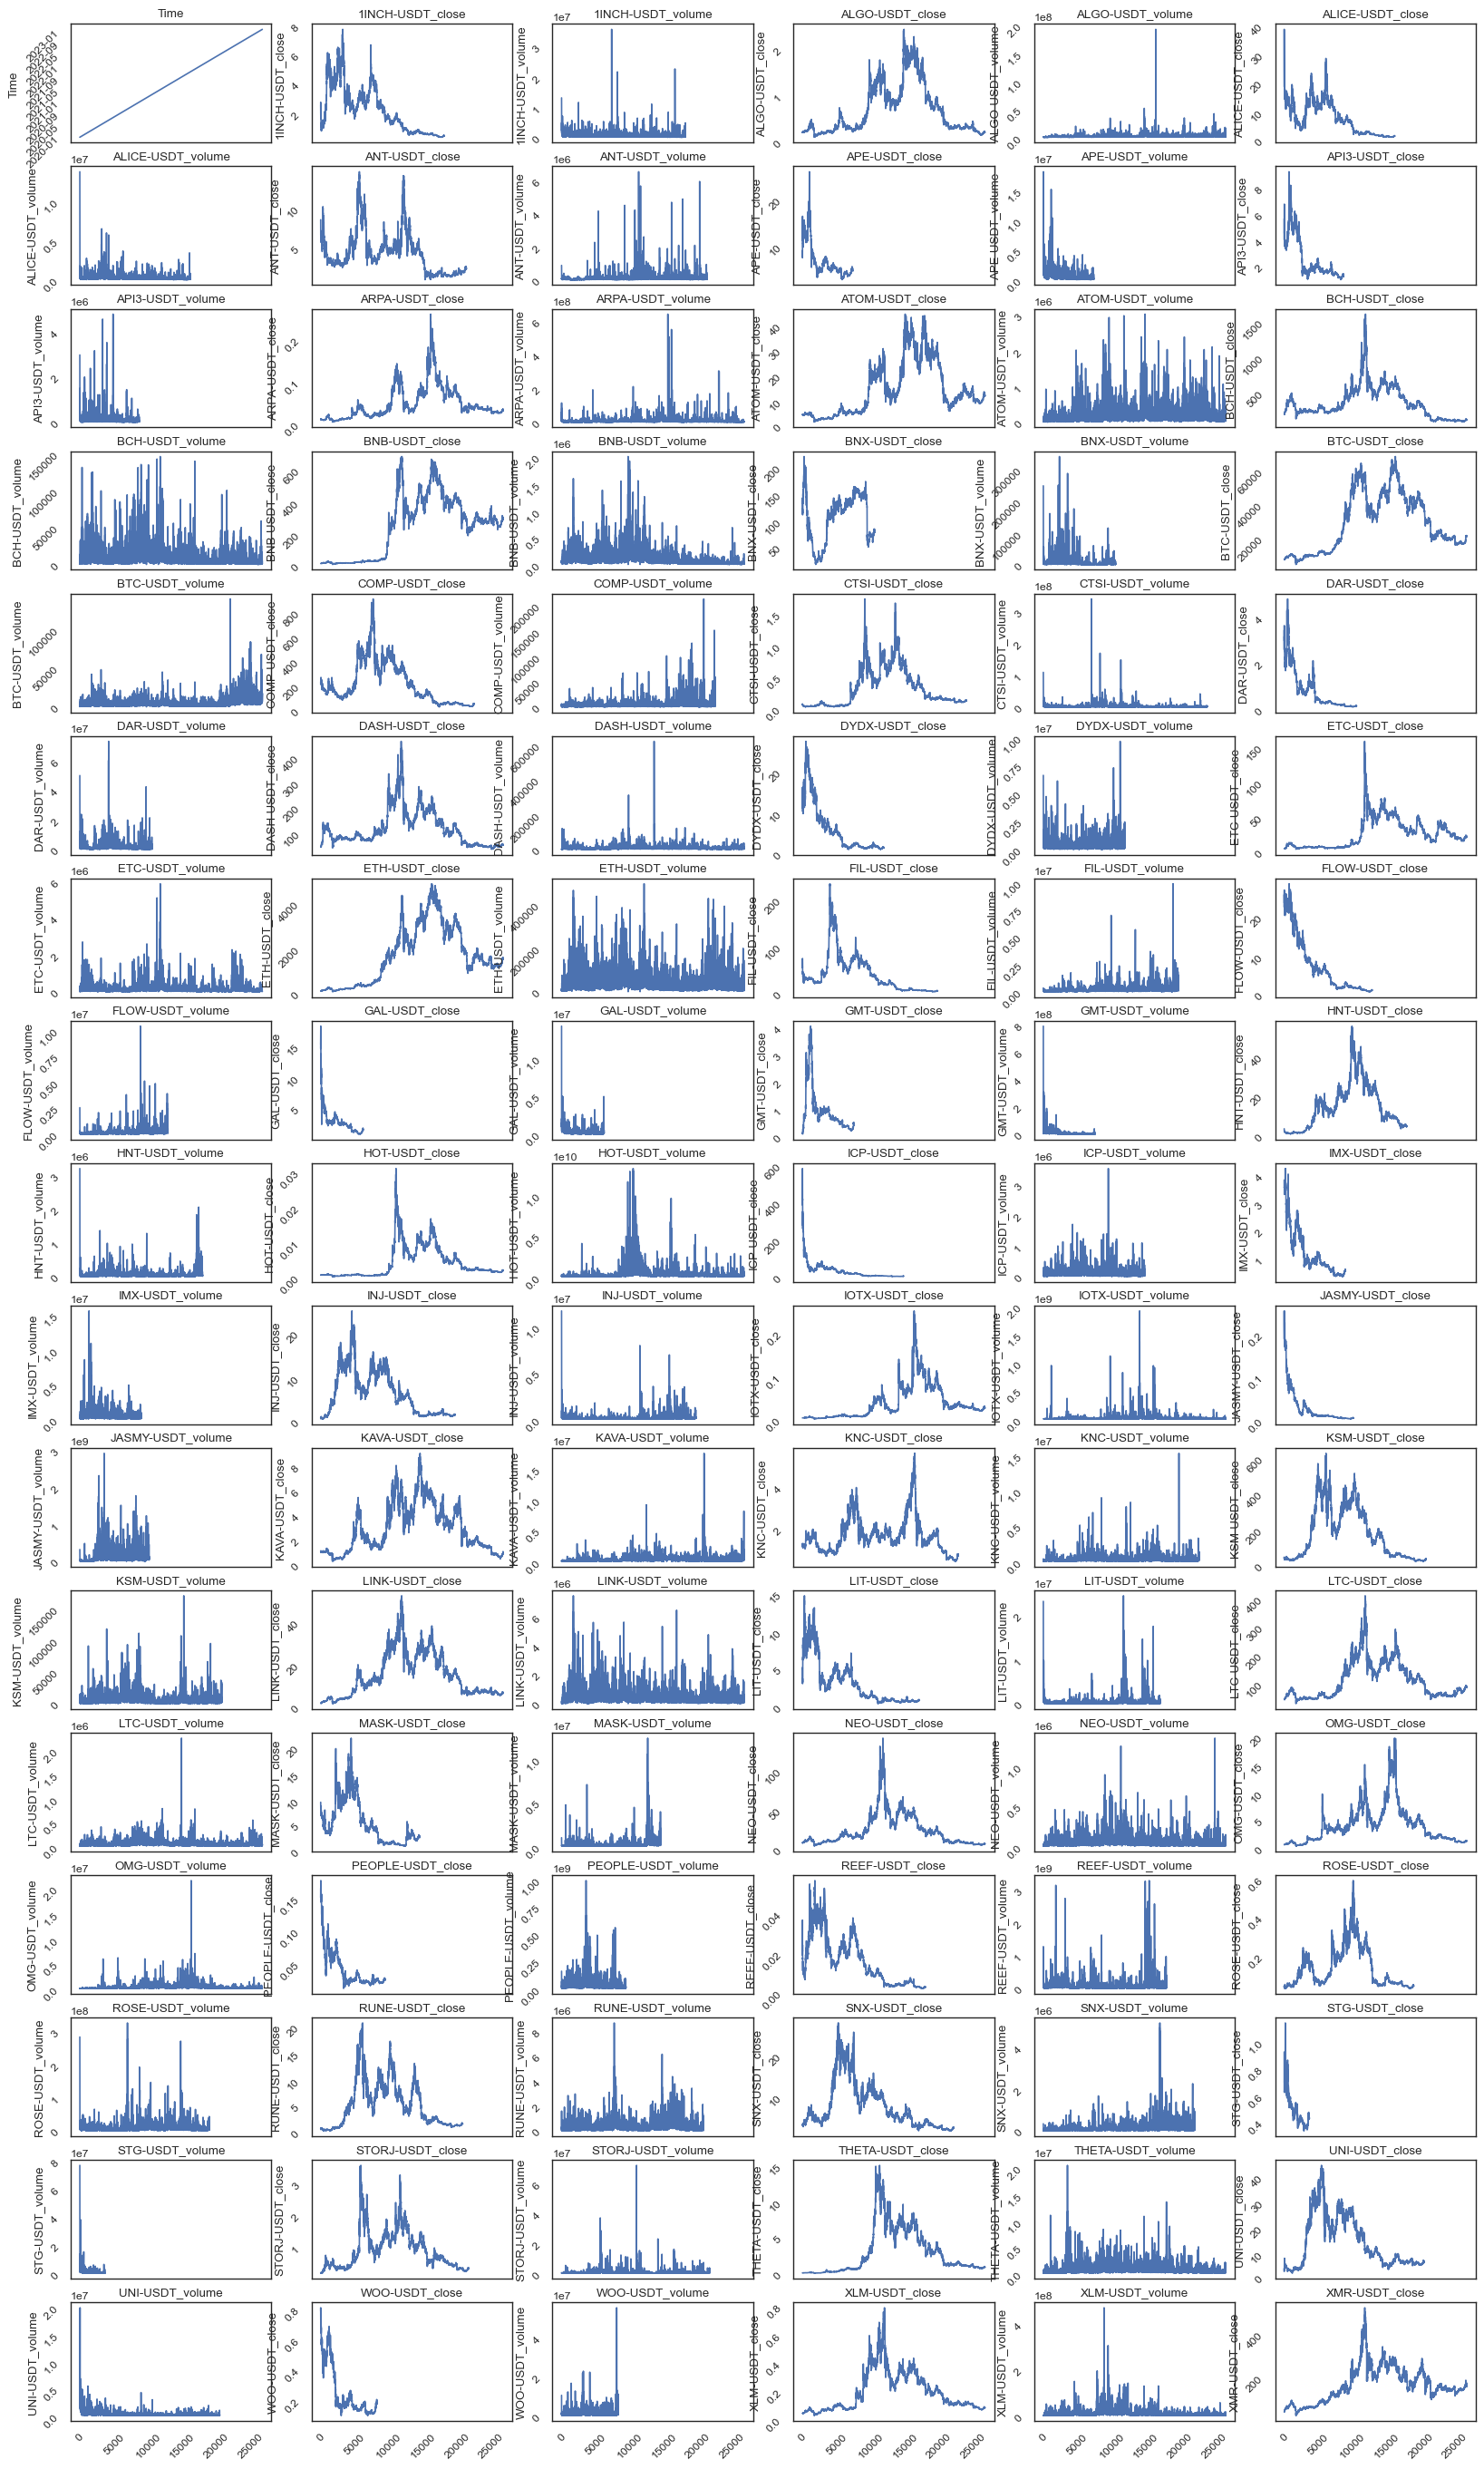

In [ ]:
# Visualizing the historical data.

# Create lineplots
list_length = df.shape[1]
ncols = 6
nrows = int(round(list_length / ncols, 0))
height = list_length/3 if list_length > 30 else 16

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(20, height))

for i, ax in enumerate(fig.axes):
        if i < list_length:
            sns.lineplot(data=df, x=df.index, y=df.iloc[:, i], ax=ax)
            ax.set_title(df.columns[i])
            ax.tick_params(labelrotation=45)

plt.show()

In [ ]:
# Matrix Calculation, we generate a matrix first that will then be colored.

sns.set(style = "white")

col_list = []
col_list = df.columns

# Computing Correlation Matrix

df_corr = pd.DataFrame(df, columns = col_list)
corr = df_corr.corr()
corr


C:\Users\hp\AppData\Local\Temp\ipykernel_5728\986520659.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_corr.corr()


,1INCH-USDT_close,1INCH-USDT_volume,ALGO-USDT_close,ALGO-USDT_volume,ALICE-USDT_close,ALICE-USDT_volume,ANT-USDT_close,ANT-USDT_volume,APE-USDT_close,APE-USDT_volume,...,THETA-USDT_close,THETA-USDT_volume,UNI-USDT_close,UNI-USDT_volume,WOO-USDT_close,WOO-USDT_volume,XLM-USDT_close,XLM-USDT_volume,XMR-USDT_close,XMR-USDT_volume
1INCH-USDT_close,1.000000,0.174355,-0.744209,-0.202219,0.509305,0.292677,0.000218,-0.170016,-0.021461,0.097108,...,-0.668441,-0.113709,0.204324,0.157355,-0.064782,0.146878,-0.660948,-0.013400,-0.698192,-0.103260
1INCH-USDT_volume,0.174355,1.000000,-0.189667,-0.073539,0.203029,0.171868,0.061021,-0.009217,0.226705,0.243967,...,-0.162589,-0.058726,-0.053970,0.262505,0.255159,-0.004068,-0.170438,-0.032247,-0.180957,-0.048959
ALGO-USDT_close,-0.744209,-0.189667,1.000000,0.221691,-0.689845,-0.185775,-0.231876,0.159790,-0.084335,-0.018795,...,0.805600,0.135729,-0.336137,-0.205943,-0.119112,-0.111637,0.821085,0.085830,0.777613,0.124457
ALGO-USDT_volume,-0.202219,-0.073539,0.221691,1.000000,-0.261029,-0.079430,-0.051973,0.018809,-0.180303,-0.092406,...,0.125559,0.204129,-0.001850,-0.083156,-0.203616,-0.038583,0.161987,0.164450,0.175758,0.219160
ALICE-USDT_close,0.509305,0.203029,-0.689845,-0.261029,1.000000,0.286993,0.254813,-0.128401,-0.002415,0.021098,...,-0.724369,-0.057690,0.435661,0.259464,0.058609,-0.041382,-0.699342,-0.107956,-0.732619,-0.190237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WOO-USDT_volume,0.146878,-0.004068,-0.111637,-0.038583,-0.041382,0.142138,-0.079710,-0.035118,-0.101313,-0.051149,...,0.015988,0.001135,0.018908,-0.020675,-0.094291,1.000000,0.041791,-0.043324,-0.020262,0.019240
XLM-USDT_close,-0.660948,-0.170438,0.821085,0.161987,-0.699342,-0.163706,0.047986,0.182112,-0.261570,-0.230127,...,0.898257,0.169124,-0.114280,-0.244241,-0.413263,0.041791,1.000000,0.278651,0.882510,0.227899
XLM-USDT_volume,-0.013400,-0.032247,0.085830,0.164450,-0.107956,-0.032717,0.140331,0.006469,0.034993,-0.035898,...,0.132444,0.226531,0.210598,-0.061904,-0.110181,-0.043324,0.278651,1.000000,0.104284,0.300737
XMR-USDT_close,-0.698192,-0.180957,0.777613,0.175758,-0.732619,-0.209884,-0.078378,0.196745,-0.191605,-0.151022,...,0.882611,0.105138,-0.263140,-0.269749,-0.433264,-0.020262,0.882510,0.104284,1.000000,0.202917


C:\Users\hp\AppData\Local\Temp\ipykernel_5728\4144575061.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype = np.bool))


<AxesSubplot: >

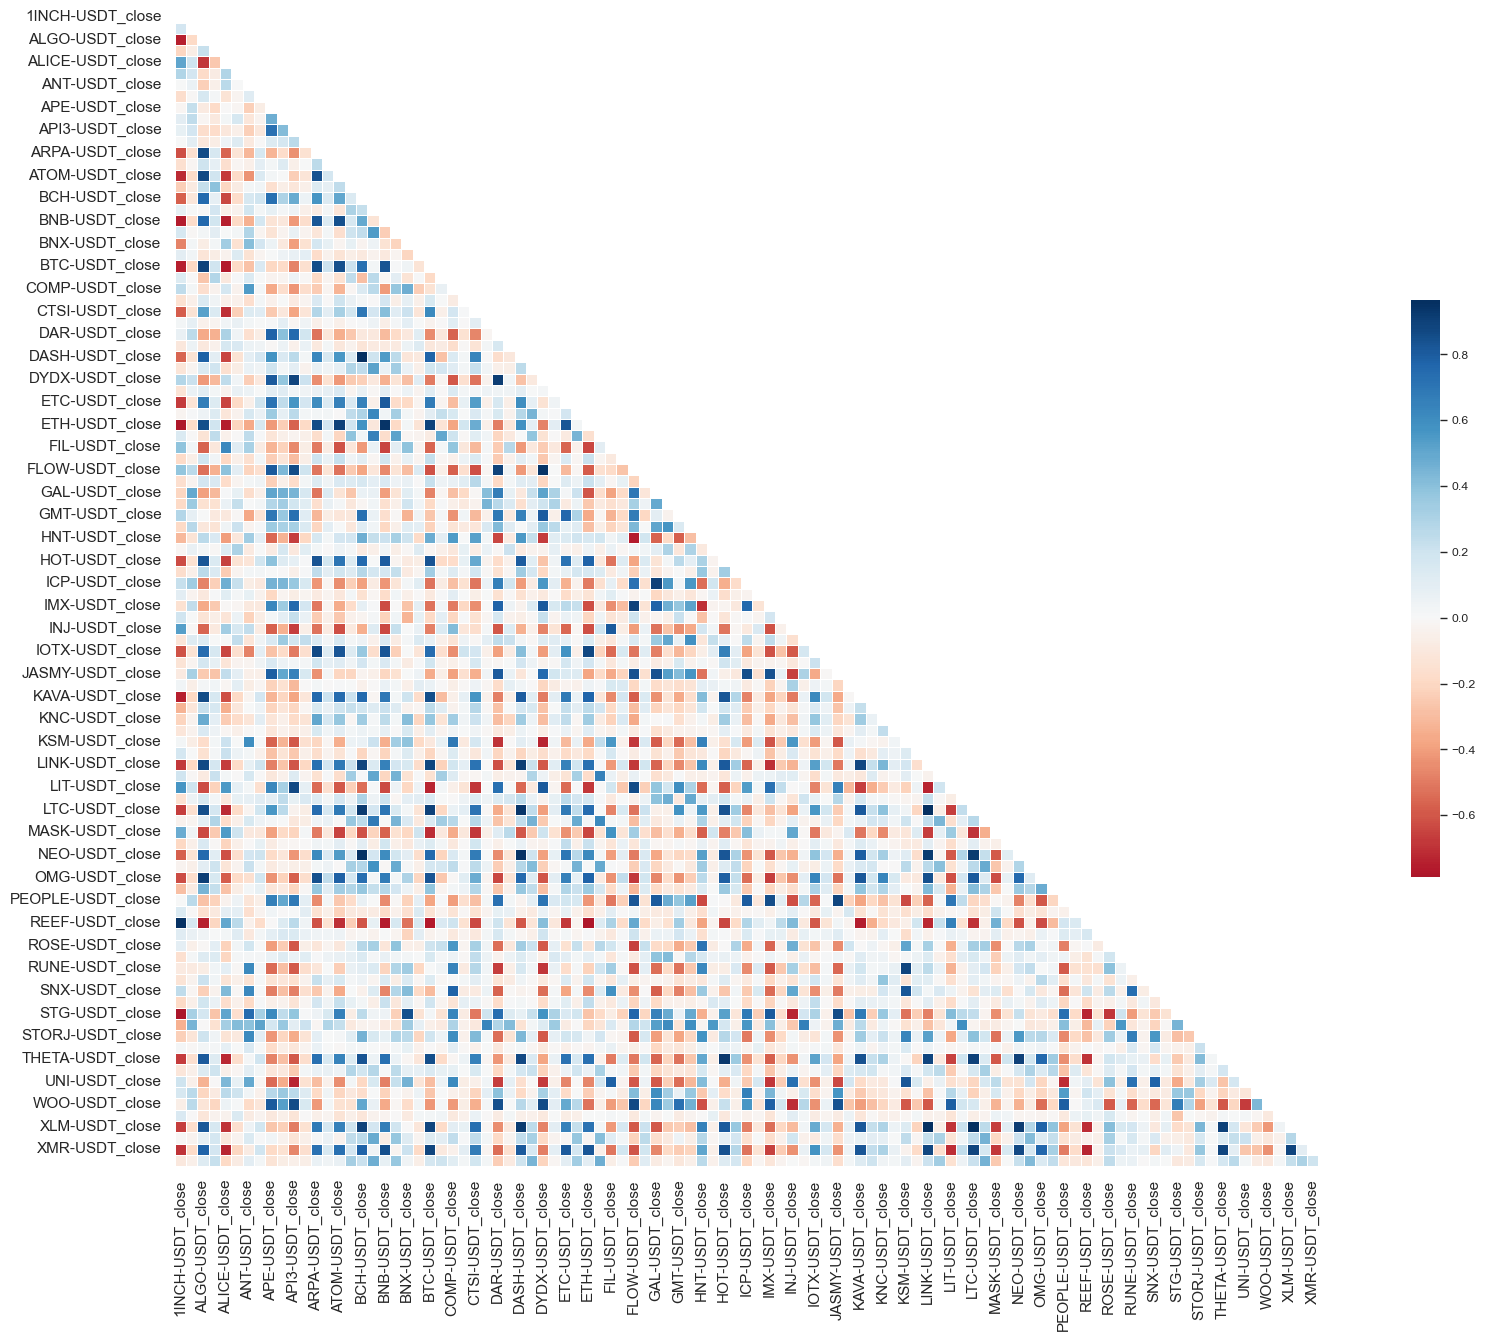

In [ ]:
# Visualizing the Correlation Matrix

# Masking the upper triangle
mask = np.triu(np.ones_like(corr, dtype = np.bool))

# Matplotlob figure
f, ax = plt.subplots(figsize=(21,15))
# Map Colors
cmap = 'RdBu'

# Heatmap with mask and aspect ratio
sns.set_context("paper", font_scale = 1)
sns.heatmap(
    corr, mask = mask, cmap = cmap, center = 0, square = True, linewidths = 0.5, cbar_kws={"shrink":0.5}
)


The correlation matrix reveals many strong direct and indirect correlations at first.

But given the difficult readability of the map above we will filter the strongest correlations, store them in a list then and print them.


In [ ]:
# Correlation Filter Function
# Let's use 0.75 as a filter. According to statology.com, as a rule of thumb 0.75 & -0.75 
# are indicative of strong correlations.
# Source: https://www.statology.org/what-is-a-strong-correlation/

def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = corr
    xFiltered = xCorr[((xCorr >= 0.75) | (xCorr <= -0.75)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened
# corr is the final correlation file obtained before.

correlation_list = (corrFilter(corr, .75)).dropna()

In [ ]:
# Saving the filered correlation list
# Delete substring '_close' for better readability

correlation_list.to_csv("USDT_denominated_correlation_list_Jan_2020-Jan_19_2013.csv")

correlation_table = pd.read_csv("USDT_denominated_correlation_list_Jan_2020-Jan_19_2013.csv")
correlation_table = correlation_table.applymap(lambda x: x.strip('_close') if isinstance(x, str) else x)
correlation_table.to_csv("1_USDT_denominated_correlation_list_Jan_2020-Jan_19_2013.csv", index = False)

print("Strongest Correlations are:")
print(correlation_table)

Strongest Correlations are:
     Unnamed: 0 Unnamed: 1         0
0    1INCH-USDT   STG-USDT -0.788906
1    1INCH-USDT   ETH-USDT -0.781818
2     REEF-USDT   ETH-USDT -0.780549
3      BTC-USDT  REEF-USDT -0.766255
4    ALICE-USDT   BTC-USDT -0.763533
..          ...        ...       ...
161    BCH-USDT   NEO-USDT  0.948308
162   LINK-USDT   LTC-USDT  0.952720
163   LINK-USDT   XLM-USDT  0.957644
164   DASH-USDT   BCH-USDT  0.963511
165    XLM-USDT   LTC-USDT  0.965234

[166 rows x 3 columns]
